# 25 - 合成双重差分

在前面的章节里，我们已经讨论了双重差分（Difference‑in‑Differences，DiD）和合成控制（Synthetic Control）两种方法，用面板数据（即在多个时间段观察多个单位的数据）识别处理效应。事实证明，我们可以将这两种方法合并为一个新的估计器。这种新的**合成双重差分**估计程序同时利用两种方法的优点，并提高了处理效应估计的精度（缩小误差区间）。

本章主要讨论**块式处理分配**的情况。这意味着我们在多个时间段观察多个单位，并且**在同一时间**只有一部分单位接受处理，而另一部分单位保持未处理。可以将这种分配表示为一个处理指示矩阵 $D$，其中**矩阵的列对应单位**，**矩阵的行对应时间段**：

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

为了更具体一些，我们继续以加利福尼亚州通过 **Proposition 99** 对香烟消费的影响为例。在这个例子中，我们只有一个被处理的单位——加利福尼亚州——它在某个时间（1988 年 11 月）通过了提案。如果我们把加州作为矩阵的最后一列，那么矩阵变成：

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$

这里我们只讨论所有被处理单位在**同一时间**接受处理的情况。最后，我们还将讨论如何处理**分批（staggered）采用的处理分配**，即处理逐步推广至各单位，导致它们在不同时间受到处理。此设计唯一要求的是：一旦一个单位接受处理，它就不会回到未处理状态。

回到简单情况，即所有单位在同一时间接受处理，我们可以把处理指示矩阵简化为四个块，每个块对应一个矩阵。一般来说，矩阵向下表示时间向后，我们也把被处理的单位分组放在矩阵右边。这样，矩阵左上角（第一块）对应处理前的控制单位；右上角（第二块）对应处理前的被处理单位；左下角（第三块）包含处理后的控制单位；右下角（第四块）是处理后的被处理单位。处理指示在所有位置为零，除了“处理后且被处理”这一块：

$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$

这种分配矩阵会导致下列结果矩阵：

$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$

再次注意，处理后期在矩阵的下方，被处理单位在右侧。

在分析 Proposition 99 的效应时，结果 $Y$ 是香烟销售量。我们用 $pre$ 和 $post$ 分别表示处理前和处理后时期，用 $co$ 和 $tr$ 分别表示控制单位和被处理单位。

在估计合成控制权重时我们将使用上述矩阵表示，但还有另一种数据表示方式也很有用，特别是在讨论双重差分时。这种表示是一个包含 5 列的表：一列表示单位，一列表示时间段，一列是结果变量，还有两列布尔变量分别标记“该单位是否属于处理组”和“该时期是否属于处理后”。该表的行数等于单位数 $N$ 乘以时期数 $T$。对于 Proposition 99 的数据，它看起来是这样的：


In [7]:
import numpy as np
import pandas as pd
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

pd.set_option('display.max_columns', 10)

In [9]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [11]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


如果想从这种表格形式回到我们之前讨论的矩阵表示，只需按时间（年份）和单位（州）进行透视。我们将在这两种表示之间来回转换，因为一种表示更适用于双重差分，另一种更适用于合成控制的估计。


In [16]:
data_piv = data.pivot(index="year", columns="state", values="cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})
data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


从潜在结果的角度，我们可以回到结果矩阵，以重新审视我们的因果推断目标。由于处理只在处理后时期施加于被处理单位，我们在整个矩阵中都观察到潜在结果 $Y_0$，除了右下角那一块。

$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$

我们的目标是估计 $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$。为此，我们需要以某种方式估计缺失的潜在结果 \(\pmb{Y}(0)_{post, tr}\)。换句话说，我们要知道：在处理后时期，如果该单位没有接受处理，其结果会是多少。考虑到这一点，一个很好的起点是回顾双重差分和合成控制。这两种方法乍看起来采取了截然不同的方式来估计这一缺失的潜在结果，将它们结合起来似乎很奇怪。不过，它们之间的共同之处要比你想象的多。


## 双重差分回顾

在“双重差分”章节中，我们通过估计下面的线性模型来得到处理效应：

$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i\, Post_t + e_{it}
$$

其中 `post` 是一个时间虚拟变量，表示该时期是在处理之后，`treated` 是一个单位虚拟变量，用来标记该单位是否属于处理组。在加州的例子中估计该模型，我们得到 $ATT=-27.34$，表明 Proposition 99 对香烟消费的影响是显著负的。这意味着人均香烟消费减少了约 27 包。


In [20]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


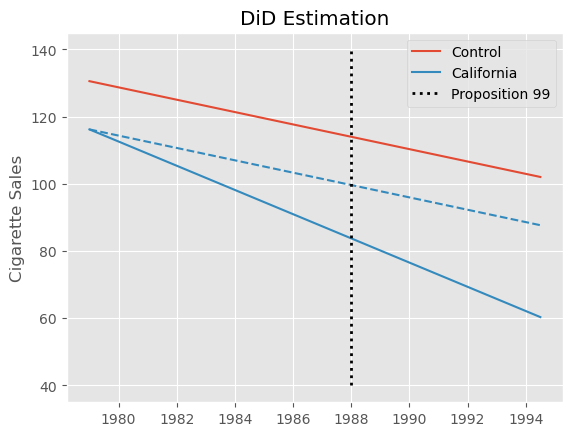

In [22]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

不过，这个估计值要谨慎看待。我们知道，双重差分假设在没有处理的情况下，控制组的趋势应该与处理组相同。形式上是 $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$。这是一个无法检验的假设，但通过查看加州（被处理单位）和其他州的处理前趋势，我们可以判断其合理性。具体地，我们会发现加州的 `cigsale` 下降速度快于其他州的平均水平，至少在处理前时期就是如此。如果这种趋势在处理后继续存在，那么双重差分估计器将会向下偏，意味着真实的效应其实没有我们上面估计的那么极端。


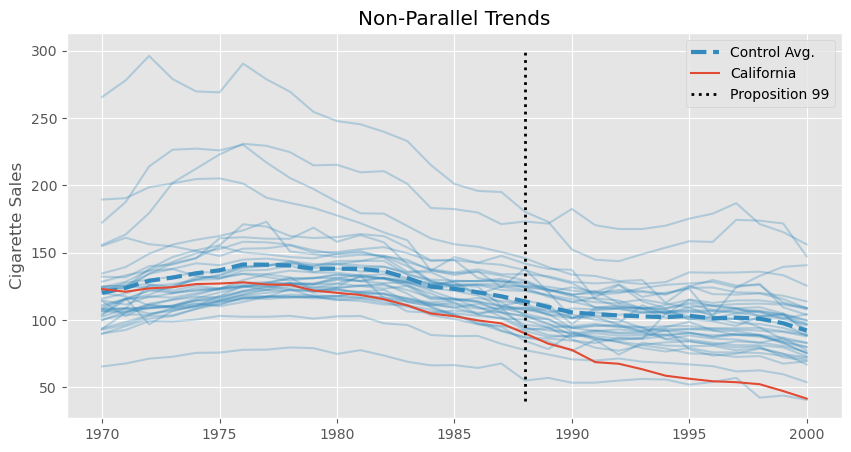

In [25]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

非平行趋势的问题正是合成控制在合成双重差分模型中发挥作用的地方。不过我们先不要跑得太快。无论上面的数据是否适合用双重差分建模，令人感兴趣的是，我们可以把 DiD 重写成双向固定效应（Two‑Way Fixed Effects，TWFE）的形式。为了这样表述 DiD，我们会拟合单位效应（$\alpha_i$）和时间效应（$\beta_t$），再加上处理指示变量：

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{\arg\min} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

在这种表述中，单位效应捕捉各单位截距的差异，而时间效应捕捉处理组和控制组共同的整体趋势。实现这一点，我们可以在回归中加入时间和单位的虚拟变量，也可以将数据去均值。在去均值过程中，我们同时从结果和处理变量中减去跨时间和跨单位的平均值：

$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$

其中，$\bar{X}_i$ 是单位 $i$ 在所有时间段的平均值，$\bar{X}_t$ 是时间 $t$ 在所有单位的平均值：

$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{T} Y_{it}  - N^{-1}\sum_{i=0}^{N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{T} D_{it} - N^{-1}\sum_{i=0}^{N} D_{it}
$$

在去均值之后，只需用 `treat*post` 回归结果变量，就可以得到双重差分估计量。


In [28]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


正如你所见，我们得到的参数与之前完全相同。毕竟，这两种做法只是看待同一双重差分估计器的不同方式。然而，这种表述之所以更有趣，是因为它让我们看到 DiD 实际上与合成控制非常相似。仔细观察上面的 TWFE 表述，它是一个同时包含时间效应和单位效应的回归问题。但请注意，其优化目标里没有任何权重。这正是双重差分与合成控制的主要区别，稍后我们会看到。

## 合成控制回顾

在经典的合成控制估计器中，我们寻找单位（州）权重，使得被处理单位在处理前的结果与控制单位的加权平均结果之间的差异最小（在没有协变量的情况下）。同时要求这些权重为正且和为 1。为找到这些权重，我们求解以下优化问题：

$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}}\; \|\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}\|^2_2 \\
\text{s.t. } \sum w_i = 1 \text{ 且 } w_i > 0 \; \forall i
$$

其中，结果矩阵 \(\pmb{Y}_{pre, co}\) 是一个 \(T_{pre}\times N_{co}\) 的矩阵，列对应单位，行对应时间段；\(\pmb{w}_{co}\) 是一个 \(N_{co}\times 1\) 的列向量，每个元素对应一个单位。最后，\(\pmb{\bar{y}}_{pre, tr}\) 是一个 \(T_{pre}\times 1\) 的列向量，其中的每个元素都是被处理单位在处理前时期的时间平均。这就是我们有时将合成控制称为“横向回归”的原因：在大多数回归中，单位是矩阵的行，但在这里单位是列。我们将被处理单位的平均结果回归到控制单位上。

一旦找到了满足上述优化问题的权重，就可以在所有时间段上将它们与控制单位相乘，得到被处理单位的合成控制：

$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$

此时认为 \(\pmb{y}_{post, sc}\) 是缺失潜在结果 \(Y(0)_{post, tr}\) 的良好估计。如果情况如此，ATT 就是处理后时期被处理单位的平均结果减去合成控制的平均结果：

$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$


In [35]:
from sc import SyntheticControl


sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment & ~treated").pivot(index="year", columns="state", values="cigsale")
y_tr_pre = data.query("~after_treatment & treated").set_index("year")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)

sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")
sc = data.query("~treated").pivot(index="year", columns="state", values="cigsale").dot(sc_weights)

att = data.query("treated").set_index("year")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


这个估计值要比我们用双重差分得到的要小得多。合成控制能够更好地处理处理前的非平行趋势，因此不会像双重差分那样受到同样的偏误。实际上，构造合成控制的过程在处理前时期强制让趋势平行。结果是，我们得到的估计更小，也更合理。

我们可以通过绘制加州的实际结果与合成控制的结果来直观展示这种估计过程。我们还用虚线绘制了干预后加州和合成控制的平均值。这两条水平线之间的差异即为估计的 $ATT$。


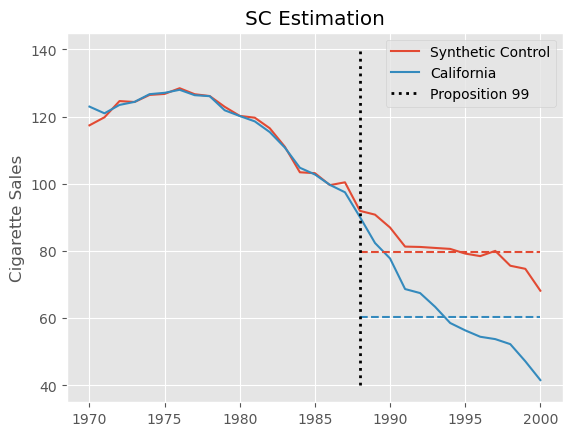

In [38]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

有意思的是，我们还可以将合成控制估计器重写为如下的优化问题，这与我们用在双重差分中的双向固定效应形式非常相似：

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{\arg\min} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

其中，控制单位的权重 $\hat{w}^{sc}_i$ 来自之前的优化问题。对于被处理单位，其权重简单地设为 $1/N_{tr}$（均匀权重）。

请注意这里合成控制和双重差分的区别。首先，合成控制在优化目标中引入了单位权重 $\hat{w}^{sc}_i$；其次，它包含时间固定效应 $\beta_t$，但没有单位固定效应 $\alpha_i$，也没有总体截距……


In [41]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


我们刚刚看到，SC 和 DiD 这两种方法其实关系密切。现在我们准备介绍合成双重差分（Synthetic Diff‑in‑Diff）。顾名思义，我们会在 DiD 估计器中加入权重，或者在合成控制估计器中加入单位固定效应。

![img](./images/25/both-pills.png)

## 合成双重差分

在正式介绍合成双重差分估计器之前，我们先把前面 SC 和 DiD 的方程列出来，便于比较。

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{\arg\min}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{\arg\min} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

接下来，正如我所承诺的，我们可以轻松将上述方程合并为一个，同时包含两者的元素：

$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{\arg\min}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$

如你所见，我们把单位固定效应 \(\alpha_i\) 加回来了，同时保留了单位权重 \(\hat{w}_i\)。但这里还有一个新的东西，即时间权重 \(\hat{\lambda}_t\)。别担心，它们并不复杂。回忆一下单位权重 \(w_i\) 是如何使控制组的结果与被处理组的平均结果之间的差异最小化的；也就是说，我们用它们来匹配处理前的趋势。时间权重做的事情类似，只不过它匹配的是处理前和处理后时期之间的差异，它使控制组的处理前期和处理后期的平均值尽可能接近。

$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \; \|\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)\|^2_2 \\
\text{s.t. } \sum \lambda_t = 1 \text{ 且 } \lambda_t > 0 \; \forall t
$$

这里，\(\pmb{Y}_{pre, co}\) 是一个 \(T_{pre}\times N_{co}\) 的结果矩阵，行代表时间段，列代表单位。而 \(\bar{\pmb{y}}_{post, co}\) 是一个 \(1\times N_{co}\) 的行向量，其每个元素是对应控制单位在处理后时期的时间平均结果。\(\pmb{\lambda}_{pre}\) 则是一个 \(1\times T_{pre}\) 的行向量，每个元素对应一个处理前时期。换个角度看，单位权重 \(w\) 是右乘在结果矩阵上的，即 \(\pmb{Y}_{pre, co} \pmb{w}_{co}\)。这意味着我们将被处理单位在每个时间段的平均结果回归到控制单位的结果上。而现在，我们把问题翻转过来，将控制组**每个处理后时期**的平均结果回归到同一控制组在处理前的结果上。

至于处理后的时间权重，我们简单地设为 $1/T_{post}$（即均匀权重）。注意还有一个截距 \(\lambda_0\)。我们这样做是为了允许处理后时期的平均水平高于或低于所有处理前时期，这在许多具有明显趋势的应用中是常见的。

如果这些仍然有些抽象，那么接下来的代码会帮助你理解正在发生的事情。


In [54]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(index=year_col, columns=state_col, values=outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .loc[y_pre.columns]  # 保证顺序一致
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

在代码中，我们首先过滤掉被处理组。然后对处理前数据进行透视，得到矩阵 \(\pmb{Y}_{pre,co}\)。接下来，我们对处理后数据按单位分组，计算每个控制单位在处理后时期的平均结果。然后，在 \(\pmb{Y}_{pre,co}\) 的顶部添加一行全为 1 的行，这行将用作截距。最后，我们将 \(\bar{\pmb{y}}_{post, co}\) 回归到这些处理前时期（\(\pmb{Y}_{pre,co}\) 的行）上，以得到时间权重 \(\lambda_t\)。注意我们在回归时加入了权重和为 1 且非负的约束。最后，我们将截距丢弃，并将时间权重存储到一个序列中。

下面是运行上述代码在 Proposition 99 问题中得到的时间权重的结果。


In [57]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

为了更好地理解这些权重的作用，我们可以绘制 \(\hat{\pmb{\lambda}}_{pre}\, \pmb{Y}_{pre, co} +  \hat{\lambda}_0\) 作为处理前时期的一条水平线（不会被归零的部分）。在它旁边，我们绘制处理后时期的平均结果。请注意，这两条线完全对齐。我们还在次坐标轴上用红色条形展示估计的时间权重。


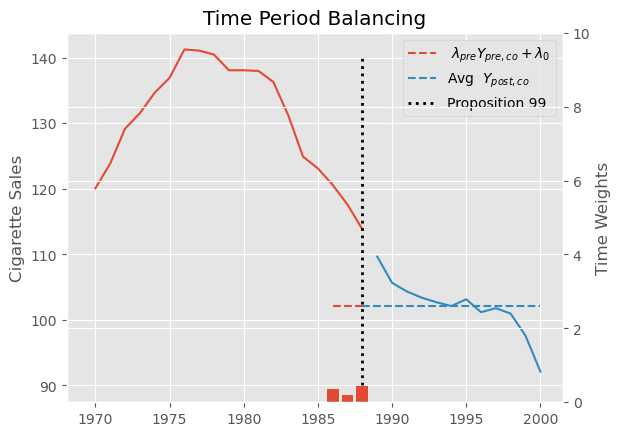

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

在了解了合成双重差分估计器中的时间权重 \(\lambda_t\) 及其估计方法之后，现在让我们把注意力转向单位权重 \(w_i\)。它们并不完全像传统合成控制中的权重。第一点不同是我们允许存在一个截距 $w_0$。这样做是因为我们不再要求被处理单位与合成控制在同一水平上。由于我们要与双重差分结合，只需要合成控制与被处理单位具有平行趋势即可。

第二点不同是我们在权重中加入了一个 $L_2$ 正则化项。这样可以使非零权重更均匀地分散到各控制单位，而不是只有少数几个单位对合成控制起作用。


In [63]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

至于单位权重，其估计并没有太多新的东西。我们可以复用用于估计时间权重的函数代码，只需注意维度，因为这个问题现在上下颠倒。


In [71]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)


首先，我们用前面定义的函数计算 \(\zeta\)，并过滤掉处理后时期。接下来，将处理前的数据透视成 \(\bar{\pmb{y}}_{pre, tr}\) 的结果矩阵。然后，在 \(\bar{\pmb{y}}_{pre, tr}\) 的开头加上一列全为 1 的列，这一列使我们能够估计截距。有了这些，我们便可以定义包含权重 $L_2$ 正则化的优化目标。最后，我们丢弃截距，把估计得到的权重存储在一个序列中。

如果用这段代码在 Proposition 99 问题中估计单位权重，下面是前 5 个州得到的结果：


In [74]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

这些单位权重也定义了一个合成控制，我们可以将其与加州的实际结果一起绘制。我们还将把之前估计的传统合成控制与刚刚估计的（加上截距）合成控制一起绘制。这将帮助我们理解其背后的直觉以及它与传统合成控制之间的差别。


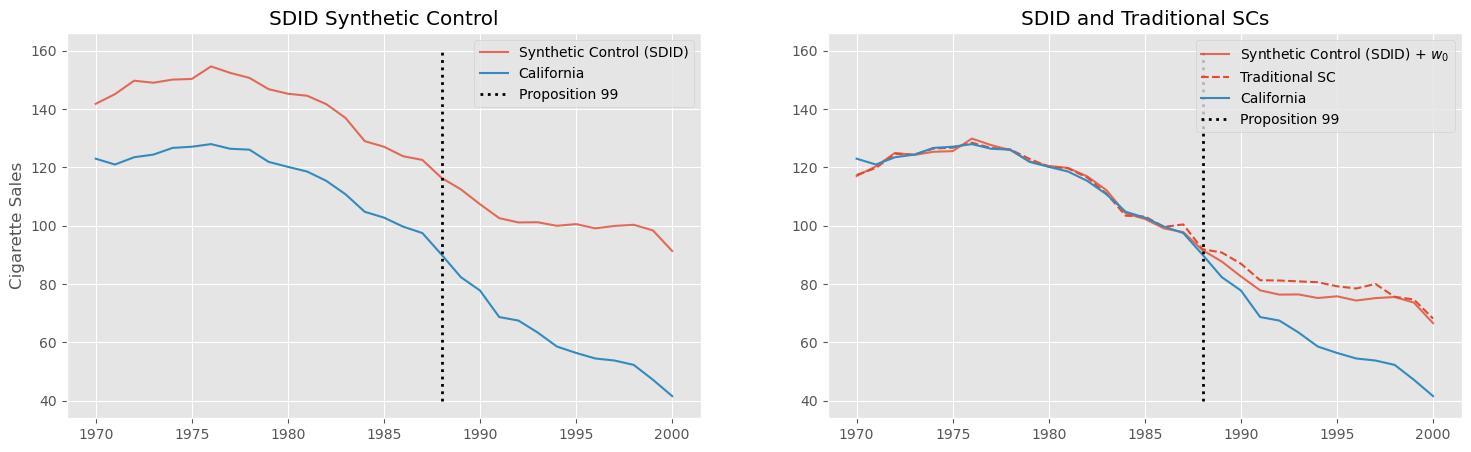

In [77]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel("Cigarette Sales");

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

如我们在第一张图中看到的，最明显的区别是新的合成控制不再与加州的水平一致。这是因为我们加入了一个截距，它允许被处理单位与其合成控制处于完全不同的水平。新的合成控制方法旨在让处理前的趋势与被处理单位一致，但不要求水平相同。

在第二张图中，我们通过重新加上之前移除的截距来平移这个新的合成控制，使其与加州重合。为了比较，我们用红色虚线展示了之前拟合的传统合成控制。注意它们并不相同。这种差异既来自我们允许存在一个截距，又来自 $L_2$ 正则化，它使权重更加分散。


In [80]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

这一拼接过程会使被处理组的单位权重和处理后时期的时间权重变成 `null`。幸运的是，由于我们在这两种情况下都使用均匀权重，很容易填补这些 `null`。对于时间权重，用处理后虚拟变量的平均值填补，即 $1/T_{post}$；对于单位权重，用被处理虚拟变量的平均值填补，即 $1/N_{tr}$。最后，将两类权重相乘即可。

下面是在 Proposition 99 数据上运行该代码得到的结果：


In [83]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600036e-14,-1.361297e-16,0.0
1,1971,1,95.400002,0,0,-4.582321e-14,-1.361297e-16,0.0
2,1972,1,101.099998,0,0,-5.274195e-14,-1.361297e-16,0.0
3,1973,1,102.900002,0,0,-5.766359e-14,-1.361297e-16,0.0
4,1974,1,108.199997,0,0,-5.617983e-14,-1.361297e-16,0.0


In [85]:
data["after_treatment"].mean()

0.3870967741935484

In [87]:
1/len(data.query("after_treatment==1")["year"].unique())

0.08333333333333333

最后，只需使用我们刚刚定义的权重来估计一个加权的双重差分模型。与处理后时期和处理组虚拟变量相互作用项相关联的参数估计就是合成双重差分估计的 $ATT$。


In [93]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.272,94.665,0.000,117.911,122.901
after_treatment,-19.1905,1.799,-10.669,0.000,-22.720,-15.661
treated,-25.2601,1.799,-14.043,0.000,-28.789,-21.731
after_treatment:treated,-15.6054,2.544,-6.135,0.000,-20.596,-10.615


这个估计值要比我们用普通双重差分得到的结果小得多，但这并不奇怪。正如我们已经讨论过的，在这里双重差分估计器很可能有偏，因为我们有充分理由质疑平行趋势假设。也许不那么明显的是，为什么 SDID 的估计比传统合成控制的估计要小。如果回头看 SC 的图，会发现早在 Proposition 99 之前，加州的香烟销售就开始低于其合成控制。这可能是因为传统合成控制需要在整个处理前时期匹配处理组和控制组，结果可能会忽略某一年或另一年。而在 SDID 中，这个问题较小，因为时间权重使我们可以仅关注那些真正重要的时期。


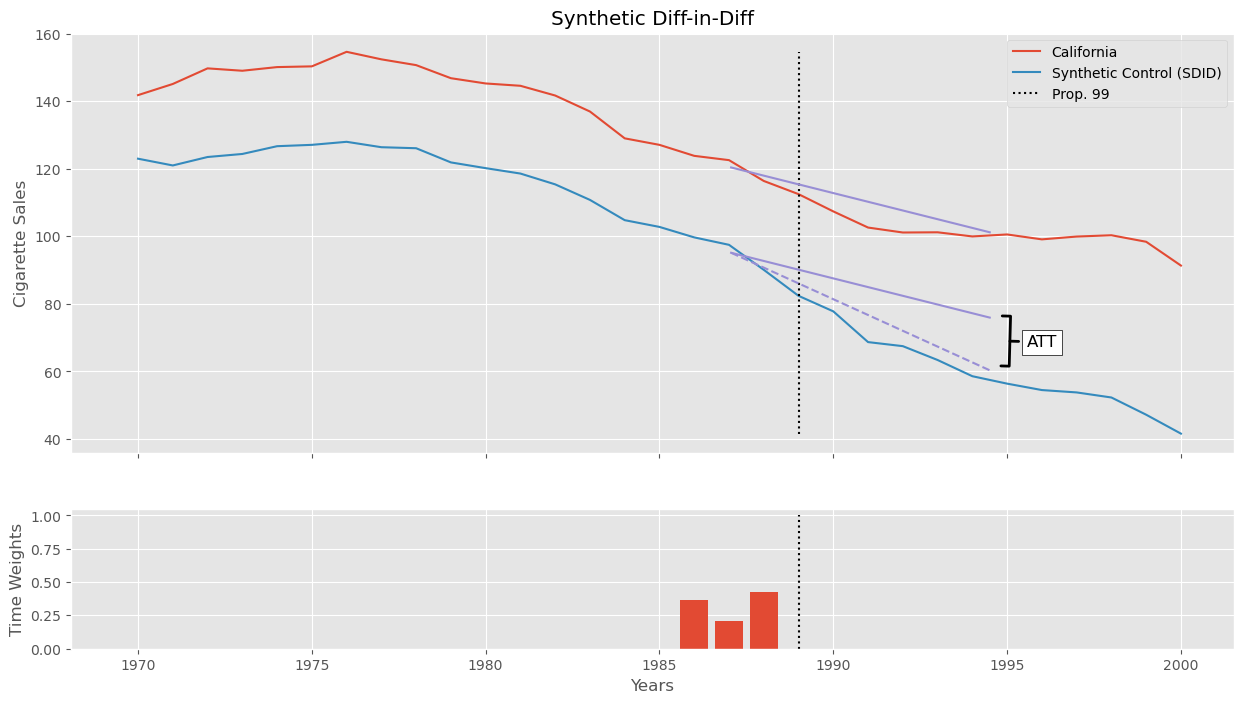

In [96]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control (SDID)")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")

ax1.annotate('ATT', xy=(1995, 69), xytext=(1996, 66.5), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=2.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

上述估计器估计的是 $ATT$，即 Proposition 99 对加州的平均效应（在所有处理后时期平均）。但从上面的图看，这个效应随着时间推移而增加。如果我们想考虑这种变化怎么办？幸运的是，这非常容易实现。

在继续之前，需要提醒一句：不要相信我们刚刚回归得到的标准误和置信区间。它们没有反映估计权重时的方差。我们稍后会简要讨论如何进行正确的推断，但首先，让我们看看如何处理随时间异质的效应。

## 时间效应异质性与分批采用

幸运的是，我们可以为每一个处理后时期单独估计一个效应……


In [99]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model.params[f"{post_col}:{treat_col}"]


synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

-15.605397234586237

现在我们已经可以轻松地运行 SDID，我们可以多次运行它，每次都只保留一个指定的处理后时期，以获得该时期的效应。


In [102]:
effects = {year: synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})"), 
                                        outcome_col="cigsale",
                                        year_col="year",
                                        state_col="state",
                                        treat_col="treated",
                                        post_col="after_treatment")
           for year in range(1989, 2001)}

effects = pd.Series(effects)

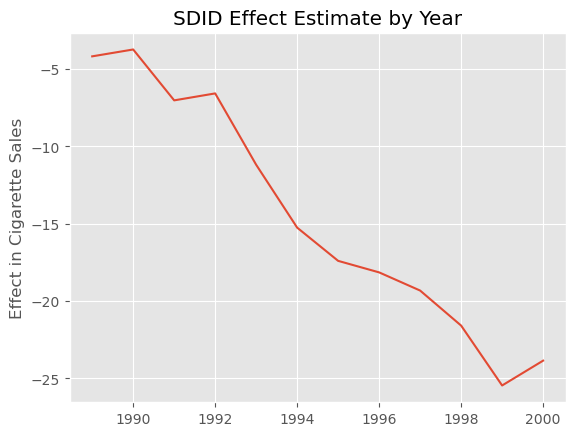

In [104]:
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

正如预期的那样，随着时间推移，效应不断增大。它起初很小，但逐渐增加，到 2020 年似乎相当于人均减少 25 包香烟。

方便的是，多次运行 SDID 在处理分批采用情形时也非常重要。在分批采用设计中，我们有多个被处理单位，它们在不同的时间接受处理。例如，回到我们非常简单的指派矩阵，假设有 3 个单位和 4 个时间段，单位 1 从未接受处理，单位 2 在第 4 个时间段接受处理，单位 3 在第 3 个时间段接受处理。这样会得到以下矩阵

$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$


In [107]:
np.random.seed(1)
n = 3
tr_state = (data
            .query(f"state.isin({list(np.random.choice(data['state'].unique(), n))})")
            .assign(**{
                "treated": True,
                "state": lambda d: "new_" + d["state"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] - 
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_state]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], False)})

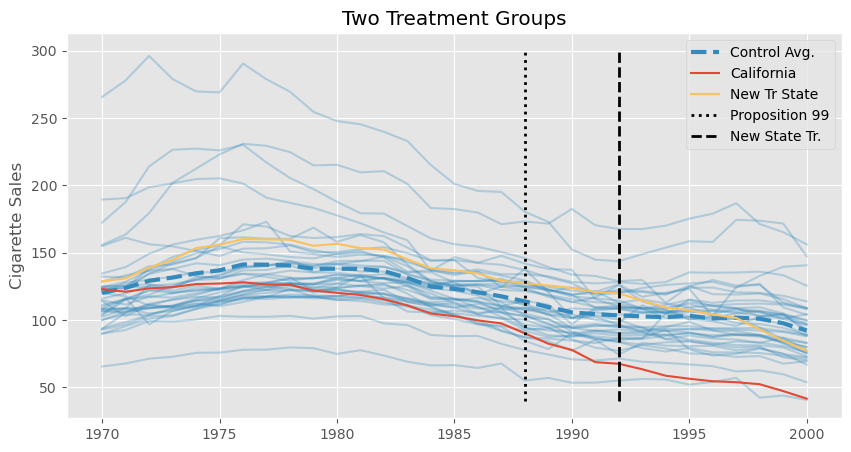

In [111]:
new_data_piv = new_data.pivot(index="year", columns="state", values="cigsale")

new_tr_states = list(filter(lambda c: str(c).startswith("new"), new_data_piv.columns))

plt.figure(figsize=(10,5))
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states), color="C1", alpha=0.3)
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_data_piv["california"], color="C0", label="California")
plt.plot(new_data_piv[new_tr_states].mean(axis=1), color="C4", label="New Tr State")

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=2, label="New State Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

我们终于得到了这份分批采用的数据。现在，我们需要想办法过滤掉一些州，以便将问题分解为多个块式指派案例。首先，我们可以按各州通过法律的时间进行分组。下面的代码就做了这件事。


In [114]:
assignment_blocks = (new_data.query("treated & after_treatment")
                     .groupby("state")["year"].min()
                     .reset_index()
                     .groupby("year")["state"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

正如你所见，我们有两组州。一组只有加州，它从 1989 年开始受到处理；另一组是我们创建的三个位于 1993 年开始受处理的新州。现在，我们需要分别对这两组运行 SDID。我们只需保留控制单位和其中一组即可轻松做到这一点。不过有一个小问题：`after_treatment` 列的含义将根据所看的组而不同。如果看的是只含加州的那组，那么 `after_treatment` 应该定义为 `year >= 1989`；如果看的是新州那一组，那么 `after_treatment` 应该定义为 `year >= 1993`。幸运的是，这很容易处理，只需要在每次迭代中重新生成 `after_treatment`。


In [117]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                   .query(f"~treated|(state.isin({states}))")
                                                   .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  state_col="state",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
                     for year, states in assignment_blocks.items()}

staggered_effects

{1989: -15.605397234586237, 1993: -17.249435402003726}

毫不意外，第一组（只包含加州）的 $ATT$ 估计与之前看到的一模一样。另一组的 $ATT$ 是我们针对新州得到的。我们需要将它们合并为一个总体 $ATT$。这可以用之前解释过的加权平均完成。

首先，计算每个块中处理实例 (`after_treatment \& treated`) 的数量。然后使用这些权重将两个 $ATT$ 组合起来。


In [120]:
weights = {year: sum((new_data["year"] >= year) & (new_data["state"].isin(states)))
           for year, states in assignment_blocks.items()}

att = sum([effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items()])

print("weights: ", weights)
print("ATT: ", att)

weights:  {1989: 12, 1993: 24}
ATT:  -16.70142267953123


这里，我们总共有 36 个处理实例：加州在处理后时期有 12 个观察值，再加上我们引入的三个新州在 1993–2000 年各有 8 个处理时期。考虑这一点，第一个 $ATT$ 的权重是 $12/36$，第二个 $ATT$ 的权重是 $24/36$，组合起来就得到上面的结果。

## 安慰剂方差估计

本章已经有点长了，但还有一个承诺没有兑现。记得开头我们说过，与合成控制相比，SDID 的精度更高（误差条更小）吗？原因是 SDID 中的时间和单位固定效应捕捉了结果的大部分变异，从而降低了估计量的方差。

当然，我不会让你只凭我的话信服，所以接下来我们将展示如何给 SDID 估计值构建一个置信区间。事实上，有许多方法可以解决这个问题，但在只有一个被处理单位（我们这里就是这种情况，因为只有加州被处理）的情况下，只有一种方法适用。其思路是运行一系列安慰剂检验：假装从控制池中抽取的某个单位被处理，实际上它并没有被处理。然后，我们用 SDID 来估计这个安慰剂检验的 $ATT$ 并保存结果。重复这个步骤多次，每次随机抽取一个控制单位。最后，我们将得到一组安慰剂 $ATT$ 值。这组值的方差就是 SDID 效果估计的安慰剂方差，我们可以用它来构建置信区间。

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}\bigg)^2
$$

$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$


In [123]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states)
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [125]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")

placebo_data.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


在上面的例子中，我们随机抽取了州 39，并假装它被处理了。注意 `treated` 列被翻转为 `True`。

下一步是用这个安慰剂数据计算 SDID 估计，并重复多次。下面的函数就是这么做的：它调用 `synthetic_diff_in_diff` 函数来获得 SDID 估计，但不是传入真实的数据，而是传入 `make_random_placebo` 的结果。重复这个过程多次，得到一个 SDID 估计的数组，最后计算该数组方差的平方根，也就是标准差。


In [128]:
from joblib import Parallel, delayed # for parallel processing


def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)
    
    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      state_col=state_col,
                      treat_col=treat_col,
                      post_col=post_col)
    
    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, state_col=state_col, treat_col=treat_col))
                                     for _ in range(bootstrap_rounds))
    
    return np.std(effects, axis=0)


In [130]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

然后，我们可以用这个标准差来构建置信区间，就像上面的公式描述的那样。


In [132]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.605397234586237
Standard Error: 9.912089736240286
90% CI: (-31.96034529938271, 0.749550830210234)


注意，在这个例子中 $ATT$ 并不显著，但更有趣的是比较 SDID 估计的标准误与传统合成控制的标准误。


In [140]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control @ w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(index=year_col, columns=state_col, values=outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att

def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [141]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.51362976399852
Standard Error: 11.241927832794818
90% CI: (-38.06281068810997, -0.9644488398870692)


可以看到，合成控制的误差高于 SDID。再次强调，这是因为 SDID 通过时间和单位固定效应捕捉了结果的大部分变异。至此，我们兑现了先前的承诺。但在结束之前，值得一提的是，我们还可以用同样的程序来估计每个处理后时期效应的方差，从而为其构建置信区间。只需对每个时间段运行一次上述代码即可。请记住，即便采用了并行化，这个过程也可能需要一些时间。


In [143]:
standard_errors = {year: estimate_se(data.query(f"~after_treatment|(year=={year})"), 
                                     outcome_col="cigsale",
                                     year_col="year",
                                     state_col="state",
                                     treat_col="treated",
                                     post_col="after_treatment")
                   for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

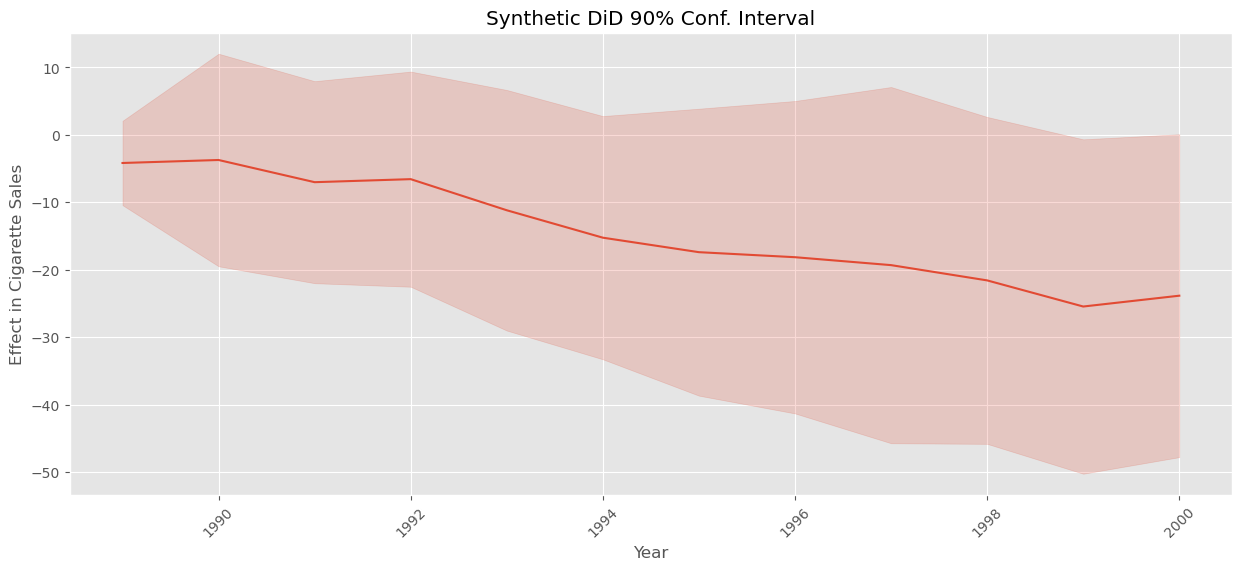

In [144]:
plt.figure(figsize=(15,6))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2,  color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## 关键观点

**合成双重差分（SDID）** 从双重差分和合成控制两种方法中汲取灵感，结合了两者的优点。与 SC 一样，当处理前趋势不平行时，SDID 仍然适用于多期面板。然而，与 SC 不同，SDID 会估计单位权重来构建控制单位，使其与处理组具有平行趋势（而不必匹配其水平）。从 DID 方面来看，SDID 利用了时间和单位固定效应，这有助于解释结果的大部分变异，从而降低 SDID 估计量的方差。合成双重差分还引入了一些自己的新思想：第一，在单位权重的优化中加入了额外的 $L2$ 惩罚，使权重更加分散到各控制单位；第二，在构建权重时允许一个截距（因此允许外推）；第三，引入了时间权重，这是 DID 和 SC 中都没有的。正因如此，SDID 并不仅仅是 SC 和 DID 的简单叠加；它是在两者启发下构建出的新方法。我也不会说 SDID 一定优于传统的合成控制或劣于它们。它们各自具有不同的特性，适用与否取决于具体情形。例如，在某些情况下，允许 SDID 的外推可能很危险，此时 SC 可能是一个更好的选择。

## 参考文献

本章基本上是对 Dmitry Arkhangelsky、Susan Athey、David A. Hirshberg、Guido W. Imbens 和 Stefan Wager 于 2019 年发表的《Synthetic Difference in Differences》一文的解读。此外，我要感谢 Masa Asami 在 Python 中实现 SDID（pysynthdid）。他的代码帮助我确保自己的实现没有错误，这非常有帮助。

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。